In [1]:
import pandas as pd
import numpy as np

# Overwrite ****** matplotlib defaults
import seaborn as sns
import matplotlib.pyplot as plt
cm = 0.393701

plt.rcParams['svg.fonttype']='none'
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.family'] = 'Arial'

plt.rcParams['figure.dpi'] = '300'

cm = 1/2.54  # centimeters in inches
# allows specifying matplotlib sizes in cm
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['figure.figsize'] = [5*cm, 4.5*cm]

plt.rcParams["font.size"] = 6

plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1

The first thing I need to do is to filter out artifacts. The most common thing is tiny dots (peppers) of signal that passed the threshold, but are too small to be considered a real signal. 

I can use the fact, that nuclei should have two spots (unless one nucleus was watershed into two, or the DNA FISH spot was split into two or multiple)

In [2]:
dmsoCHR18 = pd.read_csv("data/DMSO_250331_cp_processed_spotsCHR18.csv")
dmsoCHR18.head()

,ImageNumber,ObjectNumber,FileName_DNA,FileName_chr18,FileName_chr19,FileName_speckles,PathName_DNA,PathName_chr18,PathName_chr19,PathName_speckles,...,Location_Center_Z,Neighbors_AngleBetweenNeighbors_spotsSpeckles_1,Neighbors_FirstClosestDistance_spotsSpeckles_1,Neighbors_FirstClosestObjectNumber_spotsSpeckles_1,Neighbors_NumberOfNeighbors_spotsSpeckles_1,Neighbors_PercentTouching_spotsSpeckles_1,Neighbors_SecondClosestDistance_spotsSpeckles_1,Neighbors_SecondClosestObjectNumber_spotsSpeckles_1,Number_Object_Number,Parent_Nuclei
0,1,1,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,1.485981,71.265390,0.814262,5,0.0,0.000000,2.620786,3,1,2
1,1,2,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,1.750000,169.255337,1.056140,27,1.0,26.415094,4.940613,6,2,3
2,1,3,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,1.368750,48.708029,2.955327,7,1.0,36.842105,4.235130,35,3,3
3,1,4,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,0.843750,100.651365,4.620443,13,0.0,0.000000,5.472801,28,4,6
4,1,5,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,0.000000,31.607342,8.431066,94,1.0,66.666667,8.835221,127,5,6


I expect two spots per nucleus, I can use it to check what size cutoff is reasonable:

In [3]:
for x in range(100, 701, 50):
    tmp = dmsoCHR18[dmsoCHR18["AreaShape_Volume"] > x]
    print("threshold = ", x, "\n", 
          tmp['Parent_Nuclei'].value_counts().value_counts()[0:3])

threshold =  100 
 count
2    16
1    11
5     6
Name: count, dtype: int64
threshold =  150 
 count
2    14
1    14
5     8
Name: count, dtype: int64
threshold =  200 
 count
2    17
1    14
3     7
Name: count, dtype: int64
threshold =  250 
 count
2    16
1    15
3     9
Name: count, dtype: int64
threshold =  300 
 count
2    15
1    14
3     8
Name: count, dtype: int64
threshold =  350 
 count
1    17
2    13
3     8
Name: count, dtype: int64
threshold =  400 
 count
1    18
2    15
3     6
Name: count, dtype: int64
threshold =  450 
 count
1    18
2    16
3     6
Name: count, dtype: int64
threshold =  500 
 count
2    17
1    17
3     4
Name: count, dtype: int64
threshold =  550 
 count
1    15
2    14
3     5
Name: count, dtype: int64
threshold =  600 
 count
1    16
2    14
3     3
Name: count, dtype: int64
threshold =  650 
 count
2    16
1    12
4     2
Name: count, dtype: int64
threshold =  700 
 count
1    14
2    13
4     2
Name: count, dtype: int64


I decided to use minimal threshold at 500, which maximizes the amount of cells that have either one or two chromosome spots (17 and 17)

# Attachment to speckles

In [5]:
dmsoCHR18 = pd.read_csv("data/cellprofiler_DNA-FISH/DMSO_spotsCHR18.csv")
dmsoCHR18 = dmsoCHR18[dmsoCHR18["AreaShape_Volume"] > 500]
dmsoCHR18['treatment'] = 'DMSO'
dmsoCHR18['chromosome'] = 'chr18'

dmsoCHR19 = pd.read_csv("data/cellprofiler_DNA-FISH/DMSO_spotsCHR19.csv")
dmsoCHR19 = dmsoCHR19[dmsoCHR19["AreaShape_Volume"] > 500]
dmsoCHR19['treatment'] = 'DMSO'
dmsoCHR19['chromosome'] = 'chr19'

In [6]:
protacCHR18 = pd.read_csv("data/cellprofiler_DNA-FISH/PROTAC_spotsCHR18.csv")
protacCHR18 = protacCHR18[protacCHR18["AreaShape_Volume"] > 500]
protacCHR18['treatment'] = 'PROTAC'
protacCHR18['chromosome'] = 'chr18'

protacCHR19 = pd.read_csv("data/cellprofiler_DNA-FISH/PROTAC_spotsCHR19.csv")
protacCHR19 = protacCHR19[protacCHR19["AreaShape_Volume"] > 500]
protacCHR19['treatment'] = 'PROTAC'
protacCHR19['chromosome'] = 'chr19'

In [7]:
dmsoCHR19.head()

,ImageNumber,ObjectNumber,FileName_DNA,FileName_chr18,FileName_chr19,FileName_speckles,PathName_DNA,PathName_chr18,PathName_chr19,PathName_speckles,...,Neighbors_FirstClosestDistance_spotsSpeckles_1,Neighbors_FirstClosestObjectNumber_spotsSpeckles_1,Neighbors_NumberOfNeighbors_spotsSpeckles_1,Neighbors_PercentTouching_spotsSpeckles_1,Neighbors_SecondClosestDistance_spotsSpeckles_1,Neighbors_SecondClosestObjectNumber_spotsSpeckles_1,Number_Object_Number,Parent_Nuclei,treatment,chromosome
3,1,4,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,0.233426,113,13.0,12.682927,2.803771,82,4,9,DMSO,chr19
8,1,9,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,5.662714,46,1.0,0.185014,8.925714,161,9,8,DMSO,chr19
12,1,13,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,2.475852,92,1.0,60.393873,2.597134,236,13,3,DMSO,chr19
25,1,26,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,2.013524,147,1.0,56.920415,2.869651,103,26,4,DMSO,chr19
34,1,35,C1-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C2-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C3-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,C4-250324_SRRM2-SiR_XCP19-orange_XCP18-Green_H...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,/project/general_aktas/michal/speckle_playgrou...,...,4.259489,90,1.0,18.925234,4.912046,289,35,2,DMSO,chr19


In [8]:
df = pd.concat([dmsoCHR18[['chromosome', 'treatment', 'Parent_Nuclei', 'Neighbors_NumberOfNeighbors_spotsSpeckles_1', 'Neighbors_PercentTouching_spotsSpeckles_1', 'Neighbors_FirstClosestDistance_spotsSpeckles_1']],
                dmsoCHR19[['chromosome', 'treatment', 'Parent_Nuclei', 'Neighbors_NumberOfNeighbors_spotsSpeckles_1', 'Neighbors_PercentTouching_spotsSpeckles_1', 'Neighbors_FirstClosestDistance_spotsSpeckles_1']],
                protacCHR18[['chromosome', 'treatment', 'Parent_Nuclei', 'Neighbors_NumberOfNeighbors_spotsSpeckles_1', 'Neighbors_PercentTouching_spotsSpeckles_1', 'Neighbors_FirstClosestDistance_spotsSpeckles_1']],
                protacCHR19[['chromosome', 'treatment', 'Parent_Nuclei', 'Neighbors_NumberOfNeighbors_spotsSpeckles_1', 'Neighbors_PercentTouching_spotsSpeckles_1', 'Neighbors_FirstClosestDistance_spotsSpeckles_1']]],
               ignore_index=True)



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

chr19_DMSO vs. chr19_PROTAC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.855e-37 U_stat=2.107e+04
chr18_DMSO vs. chr18_PROTAC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.564e-04 U_stat=8.453e+03


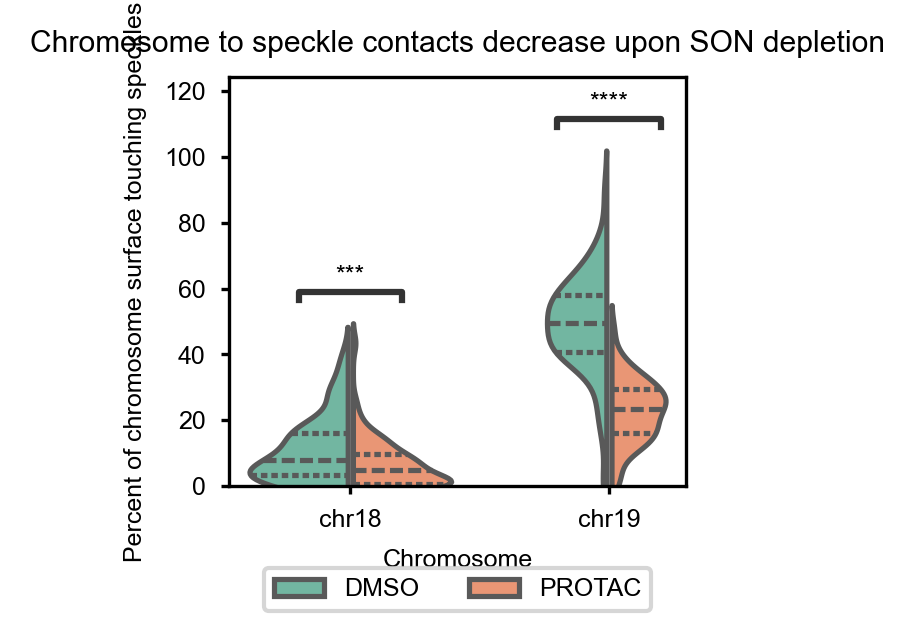

In [9]:
from statannotations.Annotator import Annotator

ax = sns.violinplot(data=df, y="Neighbors_PercentTouching_spotsSpeckles_1", x="chromosome", hue="treatment", 
               split=True, inner="quartile", gap=0.05,
               palette='Set2',)
plt.ylim(0, 120)

plt.title("Chromosome to speckle contacts decrease upon SON depletion")
plt.xlabel("Chromosome")
plt.ylabel("Percent of chromosome surface touching speckles")

annotator = Annotator(
    ax,
    pairs=[
        (("chr18", "DMSO"), ("chr18", "PROTAC")),
        (("chr19", "DMSO"), ("chr19", "PROTAC"))],
    data=df,
    x="chromosome",
    y="Neighbors_PercentTouching_spotsSpeckles_1",
    hue="treatment",
    plot="violinplot",
)

annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', borderaxespad=0., ncol=4)